In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
from scipy.linalg import norm
from scipy.spatial.distance import euclidean, jensenshannon, correlation
from scipy.stats import wasserstein_distance, ecdf
import skgstat as skg
import pysteps
from pysteps.verification.spatialscores import fss, intensity_scale
from pysteps.verification.salscores import sal
from pysteps.verification.detcontscores import det_cont_fct
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import wrf

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [14]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
soundpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/SOUNDINGS/'
models=['graphcast_','graphcast-oper','pangu_','pangu-oper','fcnv2_dawn','ifs']
references=['era','ifs_init']
figpath='/users/mfeldman/figs/scores/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black

In [133]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)

era_mod_cape=xr.open_dataset(datapath+'USA_tor_2020_cape_era5.nc').sortby('latitude').fillna(0)

cape1=era_ref.cape.values.flatten()
cape2=era_mod_cape.cape.values.flatten()
ind=np.where(cape2<200)
cape2 = np.delete(cape2,ind); cape1 = np.delete(cape1,ind)
ind=np.where(cape1<200)
cape2 = np.delete(cape2,ind); cape1 = np.delete(cape1,ind)
data = {'cape plevel': cape1,
        'cape mlevel': cape2}
dset=pd.DataFrame(data)


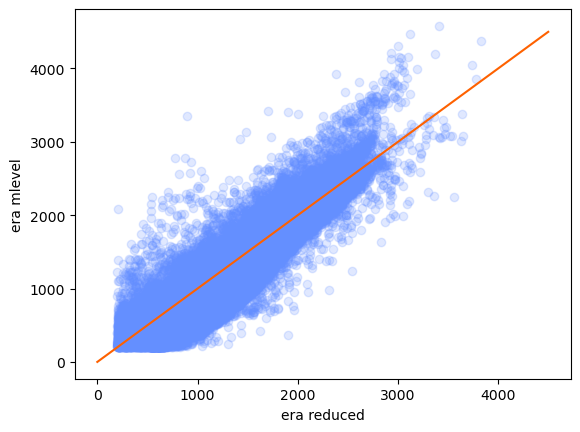

In [134]:
plt.scatter(cape1,cape2,alpha=0.2,c=c1)
plt.xlabel('era reduced')
plt.ylabel('era mlevel')
plt.plot(np.arange(4500),np.arange(4500),c=c4)
plt.show()

#era_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps_era, ter_follow=False)

making kde-plot
formatting kdeplot


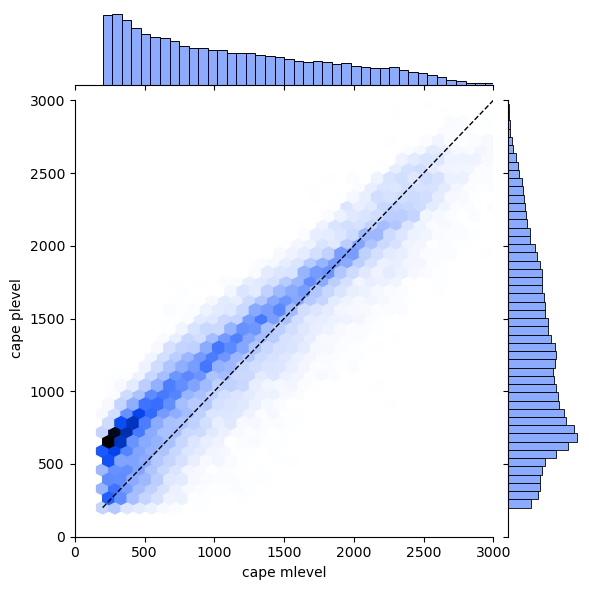

In [193]:
print('making kde-plot')
g=sns.jointplot(data=dset, x="cape mlevel", y="cape plevel", kind='hex', color=c1, 
                         xlim=(0,3000), ylim=(0,3000) )#levels=np.arange(0,1.1,0.1),, fill=True, alpha = 0.7
g.ax_joint.plot([200,3000], [200,3000], c='k', linewidth = 1, linestyle = '--')
print('formatting kdeplot')

# g.ax_joint.set_xlabel('0-6km shear [m s$^{-1}$]')
# g.ax_joint.set_ylabel('CAPE [J kg$^{-1}$]')
g.savefig(figpath+'era5_comp_kde.png')

In [122]:
stnames=['LAKE_CHARLES','JACKSON','SHREVEPORT','SLIDELL','BIRMINGHAM','FORT_WORTH']
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units

fillen = len(glob(soundpath+'*'))
fill = {'station': np.zeros(fillen),
        'date_time': np.zeros(fillen),
        'lat': np.zeros(fillen),
        'lon': np.zeros(fillen),
        'height': np.zeros(fillen),
        'cape': np.zeros(fillen),
        'cin': np.zeros(fillen),
        'lcl': np.zeros(fillen),
        'lfc': np.zeros(fillen),
        'era_cape_mlevel': np.zeros(fillen),
        'era_cape_plevel': np.zeros(fillen)}

soundings=pd.DataFrame(fill)
a=0
b=0
for stname in stnames[:]:
    files=sorted(glob(soundpath+stname+'*'))
    for file in files[:]:
        data = pd.read_csv(file,sep=';')
        data = data.sort_values(by='pressure',ascending=True)
        soundings.station[a]=stname
        soundings.date_time[a]=data.time.values[0]
        soundings.lat[a]=data.latitude.values[0]
        soundings.lon[a]=data.longitude.values[0]
        soundings.height[a]=data.elevation.values[0]

        data['spec_hum']=specific_humidity_from_dewpoint(pressure=(data.pressure.values * units.hPa), dewpoint=(data.dewpoint.values * units.degC)).magnitude

        sound_inst=wrf.cape_2d(pres_hpa=data.pressure.values, tkel=data.temperature.values+273.3, qv=data.spec_hum.values, height=data.height.values, terrain=data.elevation.values[0], psfc_hpa=data.pressure.values[0], ter_follow=False)
        print(sound_inst)
        soundings.cape[a]=sound_inst[0].values
        soundings.cin[a]=sound_inst[1].values
        soundings.lcl[a]=sound_inst[2].values
        soundings.lfc[a]=sound_inst[3].values

        c = (a - (4*(b)))*2
        ilat1 = np.argmin(abs(era_ref.latitude.values - data.latitude.values[0]))
        ilon1 = np.argmin(abs(era_ref.longitude.values - data.longitude.values[0] - 360))
        ilat2 = np.argmin(abs(era_mod_cape.latitude.values - data.latitude.values[0]))
        ilon2 = np.argmin(abs(era_mod_cape.longitude.values - data.longitude.values[0]))
        soundings.era_cape_mlevel[a]=era_ref.cape[c,ilat1,ilon1].values
        soundings.era_cape_plevel[a]=era_mod_cape.cape[c,ilat2,ilon2].values
        
        a+=1
    b+=1
    print(c,ilat2,ilon2)

        

/tmp/ipykernel_640370/4216066724.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'LAKE_CHARLES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  soundings.station[a]=stname
/tmp/ipykernel_640370/4216066724.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.date_time[a]=data.time.values[0]
/tmp/ipykernel_640370/4216066724.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2020-04-12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  soundings.date_time[a]=data.time.values[0]
/tmp/ipykernel_640370/4216066724.py:28: SettingWithCopyWarning: 
A value is trying to be 

<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([ 241.84625391,   95.45392244, 1265.11566521, 3730.49178985])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([2009.03798081,   86.83760837,  379.92660349, 3325.77683532])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([2530.80752782,   41.68776395,  761.9636765 , 1348.9475777 ])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mci

/tmp/ipykernel_640370/4216066724.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.cape[a]=sound_inst[0].values
/tmp/ipykernel_640370/4216066724.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.cin[a]=sound_inst[1].values
/tmp/ipykernel_640370/4216066724.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.lcl[a]=sound_inst[2].values
/tmp/ipykernel_640370/4216066724.py:39: SettingWithCopyWarning: 
A

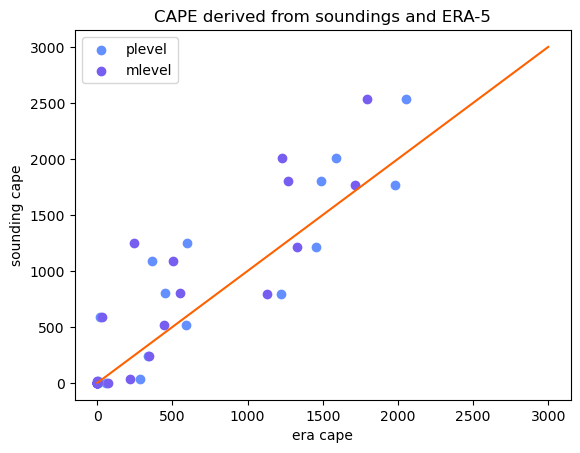

<Figure size 640x480 with 0 Axes>

In [132]:

plt.scatter(soundings.era_cape_plevel.fillna(0),soundings.cape.fillna(0),alpha=1,c=c1,label='plevel')
plt.scatter(soundings.era_cape_mlevel.fillna(0),soundings.cape.fillna(0),alpha=1,c=c2,label='mlevel')
plt.xlabel('era cape')
plt.ylabel('sounding cape')
plt.legend()
plt.plot(np.arange(3000),np.arange(3000),c=c4)
plt.title('CAPE derived from soundings and ERA-5')
plt.show()
plt.savefig(figpath+'cape_soundings.png')

In [176]:
import matplotlib.colors as colors
import matplotlib
#-- Color schemes
cmap = colors.LinearSegmentedColormap.from_list('mycmap', [c1,c2,c3,c4,c5])
matplotlib.cm.register_cmap("mycolormap3", cmap)

/tmp/ipykernel_640370/1180752591.py:5: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("mycolormap3", cmap)


/tmp/ipykernel_640370/2447317058.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'plevel' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sset.label[sset.label==1]='plevel'


making kde-plot
formatting kdeplot


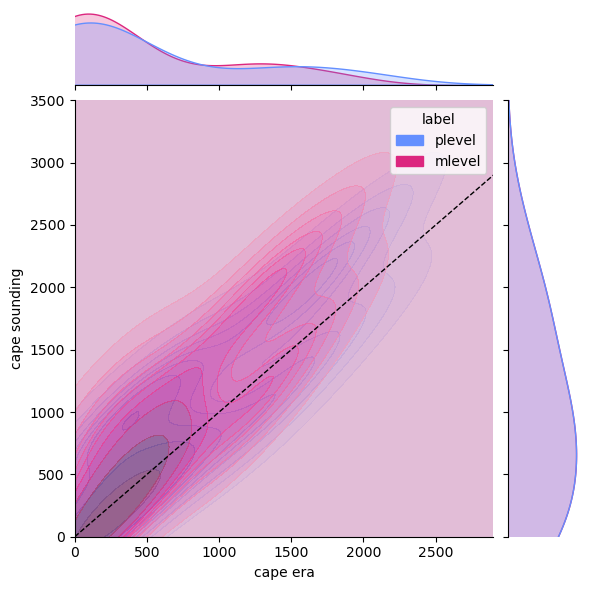

In [187]:


data = {'cape era': pd.concat([soundings.era_cape_plevel,soundings.era_cape_mlevel],axis=0,ignore_index=True),
        'cape sounding': pd.concat([soundings.cape, soundings.cape],axis=0,ignore_index=True),
        'label': np.append(np.ones(len(soundings)),(2*np.ones(len(soundings))) )}

sset=pd.DataFrame(data)
sset.label[sset.label==1]='plevel'
sset.label[sset.label==2]='mlevel'

print('making kde-plot')
g=sns.jointplot(data=sset, x='cape era', y='cape sounding', kind='kde', hue='label', palette=[c1,c3], fill=True,
                        alpha=0.6,levels=np.arange(0,1.1,0.1), xlim=(0,2900), ylim=(0,3500) )
g.ax_joint.plot([0,3500], [0,3500], 'k--', linewidth = 1)
print('formatting kdeplot')

# g.ax_joint.set_xlabel('0-6km shear [m s$^{-1}$]')
# g.ax_joint.set_ylabel('CAPE [J kg$^{-1}$]')
g.savefig(figpath+'sound_comp_kde.png')

In [158]:
sset

,cape era,cape sounding,label
0,335.358154,241.846254,plevel
1,1588.880371,2009.037981,plevel
2,2053.657715,2530.807528,plevel
3,0.000000,NaN,plevel
4,0.000000,NaN,plevel
5,452.967651,800.460703,plevel
6,1456.246582,1213.464913,plevel
7,6.149658,NaN,plevel
8,2.026611,13.847048,plevel
9,599.717285,1244.899199,plevel
